<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/Supvervised_Contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import sys
import time 
import tensorflow as tf
import pandas as pd 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
#Hyperparamter
ohe = False
projection_units = 128
input_shape = (13250,)
temperature = 0.005
learning_rate = 0.0001
epochs = 100

In [4]:
dataset_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/CUP/TCGA_FPKM_5_log.csv'

In [5]:
# Data pre-processing
# Load dataset
raw_dataframe = pd.read_csv(dataset_path, sep=',')
dataframe = raw_dataframe.copy()
print(dataframe.shape)
print(dataframe.head())
cat_label = dataframe.pop('label')
# drop gene id
dataframe = dataframe.drop(['Unnamed: 0'],axis = 1)

(14237, 13252)
                             Unnamed: 0       A2M  ...    ZNF749  label
0  3609e1bc-c1ed-4569-8b06-5c057e360ab6  1.827073  ...  0.291297   MESO
1  68a26147-3686-4e65-8eb4-9179b5bc0e57  1.602108  ...  0.274832   MESO
2  5da3d163-55d7-4310-bccb-e26e26848318  1.988105  ...  0.250790   MESO
3  da1c29c8-a1df-4f08-b685-36c4f308298b  1.639228  ...  0.288733   MESO
4  1a3a9d02-12ea-4ab9-9cb8-e333ad51bfb5  2.217213  ...  0.262579   MESO

[5 rows x 13252 columns]


In [6]:
# Dictionary for key value pair of labels 
num_classes = np.unique(cat_label)
le = preprocessing.LabelEncoder()
le.fit(cat_label)
# print(list(le.classes_))
label = le.transform(cat_label)
print("label:{}".format(label))

label:[19 19 19 ...  6  6  6]


In [7]:
classes_list = list(le.classes_)
print(classes_list)

['ACC', 'ALL', 'AML', 'BLCA', 'BRAIN', 'BRCA', 'CESC', 'CHOL', 'CML', 'CORE', 'ESCA', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'KIWT', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'MRT', 'NBL', 'NHL', 'OS', 'OV', 'PAAD', 'PCPG', 'PCT', 'PRAD', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UVM']


In [8]:
inv_label = list(le.inverse_transform(label))
used = set()
ordered_class_list = [x for x in inv_label if x not in used and (used.add(x) or True)]
print(ordered_class_list)

['MESO', 'BRCA', 'PAAD', 'UVM', 'AML', 'PCT', 'KIRP', 'LIHC', 'OV', 'CML', 'UCEC', 'TGCT', 'MRT', 'NBL', 'KIRC', 'ACC', 'ALL', 'OS', 'PCPG', 'ESCA', 'LUAD', 'KICH', 'HNSC', 'CORE', 'NHL', 'BRAIN', 'KIWT', 'CHOL', 'PRAD', 'BLCA', 'SARC', 'THYM', 'LUSC', 'THCA', 'STAD', 'SKCM', 'CESC']


In [9]:
def normal_dataframe(dataframe , norm_type  , normalize = False):
    if normalize == True:
        if norm_type =='min_max':
            min_max_scaler = preprocessing.MinMaxScaler()
            dataframe_scaled = min_max_scaler.fit_transform(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'Stand_scaler':
            scaler = preprocessing.StandardScaler()
            dataframe_scaled = scaler.fit_transform(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'zscore':
#             data_stats = dataframe.describe()
#             dataframe_scaled = (dataframe - data_stats['mean'])/ dataframe['std']
            dataframe_scaled = stats.zscore(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'MaxAbsScaler':
            max_abs_scaler = preprocessing.MaxAbsScaler()
            dataframe_scaled = max_abs_scaler.fit_transform(dataframe)
            return dataframe_scaled
            
        elif norm_type == 'log_magnitude':
            dataframe_scaled = dataframe.apply(lambda x : np.log(x+1)) 
            return dataframe_scaled.to_numpy()
        
        elif norm_type == 'log_normalize':
            dataframe_scaled = dataframe.apply(lambda x : np.log(x+1))
            nlise = preprocessing.Normalizer()
            dataframe_normalized = nlise.fit_transform(dataframe_scaled)
            return dataframe_normalized
    else:
        return dataframe.to_numpy()
    
# dataframe_scaled = normal_dataframe(dataframe ,'Stand_scaler', True)

In [10]:
dataframe_scaled = dataframe

In [11]:
#Test train Split
# dataframe = dataframe.drop(['gene_id'],axis = 1)
train, test , Y_train , Y_test = train_test_split(dataframe_scaled, label ,test_size = 0.2)
train , val , Y_train , Y_val = train_test_split(train ,Y_train , test_size = 0.2)
print("trainig data:{}".format(len(train)))
print("Validation data:{}".format(len(val)))
print("Testing data:{}".format(len(test)))
# print("Data Sample:{}".format(train[0]))

trainig data:9111
Validation data:2278
Testing data:2848


In [12]:
def label_encoder(label):
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(label)
  encoded_Y = encoder.transform(label)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y)
  return dummy_y

In [13]:
# creating label one hot encoding
if ohe:
    train_label_oh = label_encoder(Y_train)
    test_label_oh = label_encoder(Y_test)
    val_label_oh = label_encoder(Y_val)
else:
    train_label_oh = Y_train
    test_label_oh = Y_test
    val_label_oh = Y_val

print("Data Shape : Train:{} , Val :{} ,Test:{}".format(np.shape(train) ,np.shape(val), np.shape(test)))
print("Label Shape :Train:{} , Val :{} ,Test:{}".format(np.shape(train_label_oh),np.shape(val_label_oh), np.shape(test_label_oh)))
# print(train.keys())

Data Shape : Train:(9111, 13250) , Val :(2278, 13250) ,Test:(2848, 13250)
Label Shape :Train:(9111,) , Val :(2278,) ,Test:(2848,)


In [14]:
# Build encoder model
def build_cup_encoder():
    encoder_in = tf.keras.Input(input_shape)
    layer1 = Dense(10000 , activation = 'relu' , input_shape= (13250,) , name = 'Input')(encoder_in)
    layer2 = Dense(5000, activation ='relu' , name = "Hidden_Layer_2")(layer1)
    layer3 = Dense(1000, activation = 'relu' , name = 'Hidden_layer_3')(layer2)
    layer4 = Dense(500, activation = 'relu', name = 'Hidden_layer_4')(layer3)
    model = Model(inputs = encoder_in, outputs = layer4, name = 'encoder_model')
    return model

encoder = build_cup_encoder()
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13250)]           0         
                                                                 
 Input (Dense)               (None, 10000)             132510000 
                                                                 
 Hidden_Layer_2 (Dense)      (None, 5000)              50005000  
                                                                 
 Hidden_layer_3 (Dense)      (None, 1000)              5001000   
                                                                 
 Hidden_layer_4 (Dense)      (None, 500)               500500    
                                                                 
Total params: 188,016,500
Trainable params: 188,016,500
Non-trainable params: 0
_________________________________________________________________


In [15]:
def build_classifier(encoder):
    classifier_input = tf.keras.Input(input_shape)
    encoder_out = build_cup_encoder()(classifier_input)
    layer5 = Dense(100 , activation ='relu' , name = 'Hidden_layer_5')(encoder_out)
    layer6 = Dense(37 , activation = 'softmax' , name = "Output_layer")(layer5)
    
    model = Model(inputs = classifier_input, outputs = layer6, name = 'classifier_model')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = optimizer,
               metrics = [keras.metrics.SparseCategoricalAccuracy()])
    
    return model

classifier = build_classifier(encoder)

In [16]:
# Self supervised Loss
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


In [17]:
# build Projection Head
def build_projection_head(encoder):
    projection_input = tf.keras.Input(input_shape)
    encoder_output = encoder(projection_input)
    
    projection_layer = Dense(projection_units, activation="relu")(encoder_output)
    model = Model(inputs = projection_input, outputs = projection_layer)
    return model

projection_head = build_projection_head(encoder)

In [18]:
encoder = build_cup_encoder()
encoder_with_projection_head = build_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 13250)]           0         
                                                                 
 encoder_model (Functional)  (None, 500)               188016500 
                                                                 
 dense_1 (Dense)             (None, 128)               64128     
                                                                 
Total params: 188,080,628
Trainable params: 188,080,628
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train SCL
history = encoder_with_projection_head.fit(train,train_label_oh,
           validation_data=(val,val_label_oh),
           epochs = 100,
           batch_size = 64,
           shuffle = True,
           verbose=1)

Epoch 1/100
143/143 [==============================] - 17s 102ms/step - loss: 1.7919 - val_loss: 1.4707
Epoch 2/100
143/143 [==============================] - 13s 91ms/step - loss: 1.4068 - val_loss: 1.4074
Epoch 3/100
143/143 [==============================] - 13s 91ms/step - loss: 1.3391 - val_loss: 1.3692
Epoch 4/100
143/143 [==============================] - 14s 96ms/step - loss: 1.3247 - val_loss: 1.3843
Epoch 5/100
143/143 [==============================] - 14s 96ms/step - loss: 1.3023 - val_loss: 1.3346
Epoch 6/100
143/143 [==============================] - 13s 91ms/step - loss: 1.2858 - val_loss: 1.3653
Epoch 7/100
143/143 [==============================] - 13s 92ms/step - loss: 1.2703 - val_loss: 1.3142
Epoch 8/100
143/143 [==============================] - 14s 95ms/step - loss: 1.2484 - val_loss: 1.3585
Epoch 9/100
143/143 [==============================] - 13s 91ms/step - loss: 1.2381 - val_loss: 1.3080
Epoch 10/100
143/143 [==============================] - 14s 95ms/step - 

In [20]:
classifier = build_classifier(encoder)

In [ ]:
callbacks = [
    EarlyStopping(patience=25, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(factor=0.05, patience=15, min_lr=0.000000001, verbose=1,monitor='val_loss'),
    # ModelCheckpoint('/home/aayush.t/Ashick/CUP/Model/CUP_DNN_defaultNonorm_tcga.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [21]:
#Model training 
history = classifier.fit(
           train,train_label_oh,
           validation_data=(val,val_label_oh),
           epochs = 100,
           batch_size = 32,
           shuffle = True,
           callbacks=callbacks,
           verbose=1)

Epoch 1/100
285/285 [==============================] - 25s 87ms/step - loss: 1.2930 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.4737 - val_sparse_categorical_accuracy: 0.8630
Epoch 2/100
285/285 [==============================] - 24s 84ms/step - loss: 0.3316 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9447
Epoch 3/100
285/285 [==============================] - 24s 84ms/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9294 - val_loss: 0.2336 - val_sparse_categorical_accuracy: 0.9390
Epoch 4/100
285/285 [==============================] - 24s 83ms/step - loss: 0.2086 - sparse_categorical_accuracy: 0.9405 - val_loss: 0.3525 - val_sparse_categorical_accuracy: 0.9004
Epoch 5/100
285/285 [==============================] - 24s 83ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.2985 - val_sparse_categorical_accuracy: 0.9025
Epoch 6/100
285/285 [==============================] - 24s 83ms/step - loss: 0.1623 -

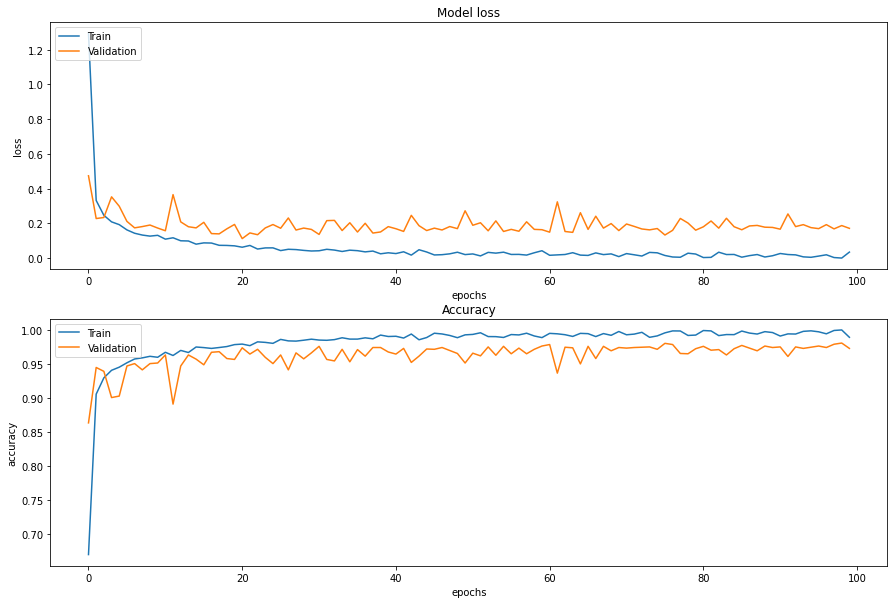

In [22]:
#Results visualization
def showloss(history):
        # loss plot
        plt.subplots(figsize=(15,10))
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Train','Validation'],loc = 'upper left')

        #accuracy plot
        plt.subplot(2,1,2)
        plt.plot(history.history['sparse_categorical_accuracy'])
        plt.plot(history.history['val_sparse_categorical_accuracy'])
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend(['Train','Validation'] , loc = 'upper left')
        plt.show()

showloss(history)

In [23]:
def predict(test):
    predictions = classifier.predict(test, verbose = 1)
    predict_index = predictions.argmax(axis=1)
    test_index = test_label_oh
    results = confusion_matrix(test_index , predict_index)


    #Classification accuracy
    accuracy = accuracy_score(test_index,predict_index)
    print("Classification accuracy:{}".format(accuracy))
    print()
    print(accuracy)

    #Classification report 
    classify_report = classification_report(test_index,predict_index)
    print("Classification report")
    print(classify_report)
    
    return test_label_oh, predictions, test_index, predict_index
    
test_label_oh, predictions, test_index, predict_index = predict(test)

89/89 [==============================] - 2s 16ms/step
Classification accuracy:0.9764747191011236

0.9764747191011236
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.98      0.99       126
           2       0.98      0.98      0.98       175
           3       0.99      0.93      0.96        84
           4       1.00      0.98      0.99       161
           5       0.98      1.00      0.99       235
           6       0.99      0.93      0.96        82
           7       0.75      0.60      0.67        10
           8       0.83      0.94      0.88        16
           9       0.99      1.00      1.00       116
          10       0.87      0.97      0.92        34
          11       0.95      0.97      0.96       113
          12       1.00      0.93      0.96        14
          13       0.95      0.98      0.96       144
          14       0.98      0.88      0.93       